In [1]:
from preprocessing import load_and_preprocess_data
from training import train_model, find_optimal_threshold, save_model
from evaluation import evaluate_model
from config import MIN_PRECISION, MIN_RECALL
from sklearn.model_selection import train_test_split

In [2]:
print("Loading and preprocessing data...")
X, y = load_and_preprocess_data()
print(f"Data shape: {X.shape} | Fraud rate: {y.mean():.2%}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

Loading and preprocessing data...
Data shape: (100000, 16) | Fraud rate: 5.00%


In [3]:
print("\nTraining model with SMOTE...")
model = train_model(X_train, y_train)


Training model with SMOTE...
Starting model training with SMOTE...
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Training complete!
Best parameters: {'classifier__colsample_bytree': 0.8, 'classifier__gamma': 0.1, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 7, 'classifier__subsample': 1.0}
Best F1 score (CV): 0.5793


In [4]:
print("\nFinding optimal threshold...")
threshold = find_optimal_threshold(
    model, 
    X_train, 
    y_train,
    min_precision=MIN_PRECISION,
    min_recall=MIN_RECALL
)
print(f"Using threshold: {threshold:.4f}")


Finding optimal threshold...
Found threshold meeting requirements: 0.5829 (F1=0.6783)
Using threshold: 0.5829



Evaluating model...
Model Evaluation Metrics:
Accuracy: 0.9545
Precision: 0.5386
Recall: 0.6280
F1: 0.5799
Roc_auc: 0.9655
Pr_auc: 0.6403


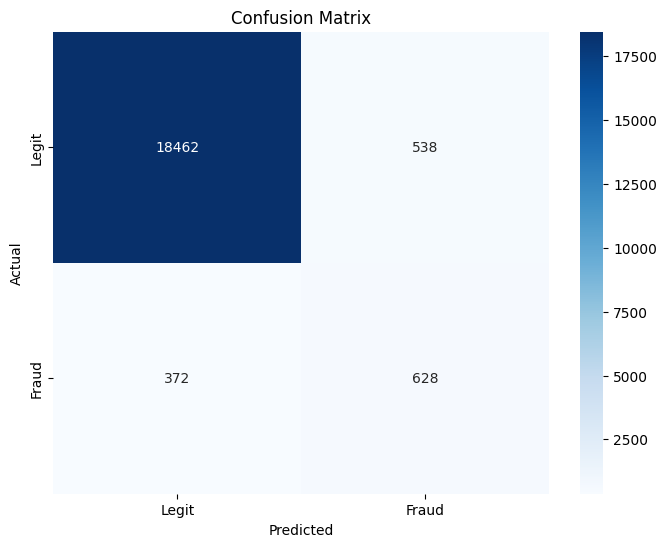

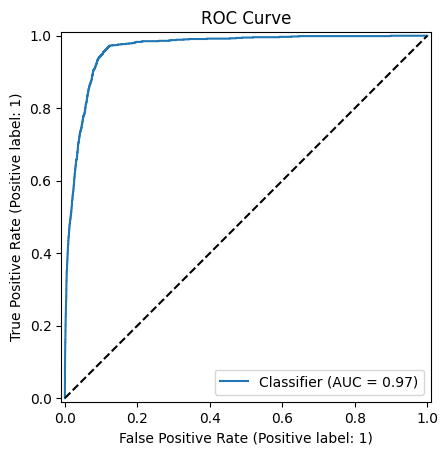

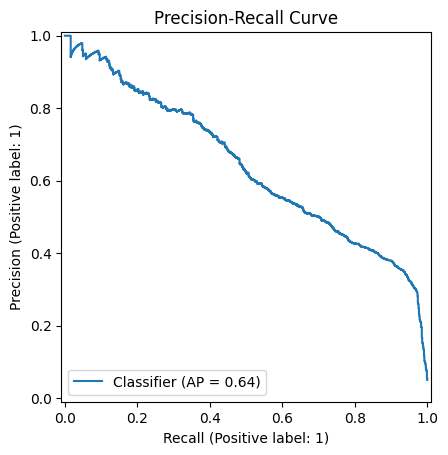

In [5]:
print("\nEvaluating model...")
metrics = evaluate_model(model, threshold, X_test, y_test)

In [6]:
print("\nSaving model components...")
pipeline_path, preprocessor_path, classifier_path, threshold_path = save_model(model, threshold)
print("\nAll components saved successfully!")


Saving model components...
Full pipeline saved to models\fraud_model_pipeline.joblib
Preprocessor saved to models\fraud_model_preprocessor.joblib
Classifier saved to models\fraud_model_classifier.joblib
Threshold saved to models\fraud_model_threshold.txt

All components saved successfully!


In [9]:
# Test inference on a sample
print("\n" + "="*50)
print("Testing inference capabilities...")
from inference import FraudPredictor

# Initialize predictor
predictor = FraudPredictor()

# Create sample transactions for testing
# In real usage, you'd have complete transaction data
sample_transactions = [
    {
        'amount': 50.0,
        'old_balance': 500.0,
        'new_balance': 450.0,
        'age': 25,
        'category': 'groceries',
        'gender': 'F',
        'transaction_type': 'purchase',
        'location': 'Los Angeles, USA',
        'timestamp': '2024-01-15 10:00:00',
        'customer_id': 'CUST001',
        'merchant': 'Super Market'
    },
    {
        'amount': 2500.0,
        'old_balance': 1000.0,
        'new_balance': -1500.0,
        'age': 45,
        'category': 'electronics',
        'gender': 'M',
        'transaction_type': 'purchase',
        'location': 'New York, USA',
        'timestamp': '2024-01-15 23:45:00',
        'customer_id': 'CUST002',
        'merchant': 'Electronics Store'
    },
    {
        'amount': 75.0,
        'old_balance': 1200.0,
        'new_balance': 1125.0,
        'age': 35,
        'category': 'dining',
        'gender': 'M',
        'transaction_type': 'purchase',
        'location': 'Chicago, USA',
        'timestamp': '2024-01-15 19:30:00',
        'customer_id': 'CUST003',
        'merchant': 'Restaurant ABC'
    }
]


Testing inference capabilities...
Model components loaded successfully
Using threshold: 0.5829


In [11]:
# Make predictions
import pandas as pd
sample_df = pd.DataFrame(sample_transactions)
predictions = predictor.predict(sample_df)
probabilities = predictor.predict(sample_df, return_proba=True)

print("\nInference test results:")
for i, (transaction, pred, prob) in enumerate(zip(sample_transactions, predictions, probabilities)):
    print(f"\nTransaction {i+1}:")
    print(f"  Amount: ${transaction['amount']:.2f}")
    print(f"  Category: {transaction['category']}")
    print(f"  Prediction: {'FRAUD' if pred else 'LEGITIMATE'}")
    print(f"  Fraud probability: {prob:.4f}")
    print(f"  Risk level: {'HIGH' if prob > 0.8 else 'MEDIUM' if prob > 0.5 else 'LOW'}")

# Also test single prediction
print("\n" + "-"*50)
print("Testing single transaction prediction...")
single_transaction = {
    'amount': 5000.0,
    'old_balance': 2000.0,
    'new_balance': -3000.0,
    'age': 22,
    'category': 'travel',
    'gender': 'M',
    'transaction_type': 'withdrawal',
    'location': 'Miami, USA',
    'timestamp': '2024-01-16 03:00:00',
    'customer_id': 'CUST999',
    'merchant': 'ATM'
}

pred, prob = predictor.predict_single(single_transaction)
print(f"\nSingle transaction result:")
print(f"  Prediction: {'FRAUD' if pred else 'LEGITIMATE'}")
print(f"  Fraud probability: {prob:.4f}")
print(f"  Risk level: {'HIGH' if prob > 0.8 else 'MEDIUM' if prob > 0.5 else 'LOW'}")


Inference test results:

Transaction 1:
  Amount: $50.00
  Category: groceries
  Prediction: LEGITIMATE
  Fraud probability: 0.0021
  Risk level: LOW

Transaction 2:
  Amount: $2500.00
  Category: electronics
  Prediction: FRAUD
  Fraud probability: 0.9884
  Risk level: HIGH

Transaction 3:
  Amount: $75.00
  Category: dining
  Prediction: LEGITIMATE
  Fraud probability: 0.0026
  Risk level: LOW

--------------------------------------------------
Testing single transaction prediction...

Single transaction result:
  Prediction: FRAUD
  Fraud probability: 0.9796
  Risk level: HIGH
